## Imports

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import ClassLabel, Dataset, DatasetDict, Features, Image, load_dataset
from energyflow.utils import (
    center_ptyphims,
    phi_fix,
    pixelate,
    ptyphims_from_p4s,
    reflect_ptyphims,
    rotate_ptyphims,
)
from tqdm.auto import tqdm

## Load data

In [28]:
ds = load_dataset("dl4phys/top_landscape")

Using custom data configuration dl4phys--top_landscape-961457c8730ac19c


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /Users/lewtun/.cache/huggingface/datasets/parquet/dl4phys--top_landscape-961457c8730ac19c/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [75]:
def convert_to_numpy(split):
    df = ds[split].to_pandas()
    return (df.to_numpy()[:, :800]).reshape(-1, 200, 4), df["is_signal_new"].values

In [76]:
events, labels = convert_to_numpy("test")

## Rotate basis

In [66]:
def rotate_basis(events):
    ptyphims = []

    for event in tqdm(events, desc="Rotating to (pT,eta,phi,m)"):
        ptyphims.append(ptyphims_from_p4s(event, phi_ref="hardest", mass=True))

    return np.array(ptyphims)

## Centre image

In [67]:
def centre_images(ptyphims):

    ptyphims_center = []

    for event in tqdm(ptyphims, desc="Centring images"):
        ptyphims_center.append(center_ptyphims(event))
    return np.array(ptyphims_center)

## Reflect and rotate

In [68]:
def reflect_and_rotate(ptyphims_center):

    ptyphims_center_rr = []
    for event in tqdm(ptyphims_center, desc="Reflect and rotate"):
        ptyphims_center_rr.append(reflect_ptyphims(rotate_ptyphims(event)))
    return np.array(ptyphims_center_rr)

## Pixelate

In [112]:
def create_images(events):
    ptyphims = rotate_basis(events)
    ptyphims_center = centre_images(ptyphims)
    ptyphims_center_rr = reflect_and_rotate(ptyphims_center)

    images = []
    for event in tqdm(ptyphims_center_rr, "Pixelate"):
        images.append(
            pixelate(
                event,
                npix=40,
                img_width=0.8,
                nb_chan=1,
                norm=False,
                charged_counts_only=False,
            )
        )
    return np.array(images).reshape(len(images), 40, 40)

In [130]:
def create_dataset():
    dsets = DatasetDict()
    features = Features({"image": Image(), "label": ClassLabel(names=["qcd", "top"])})

    for split in ["train", "validation", "test"]:
        events, labels = convert_to_numpy(split)
        images = create_images(events)
        dsets[split] = Dataset.from_dict(
            {"image": images, "label": labels}, features=features
        )

    return dsets

In [131]:
dsets = create_dataset()

Rotating to (pT,eta,phi,m):   0%|          | 0/1211000 [00:00<?, ?it/s]

Centring images:   0%|          | 0/1211000 [00:00<?, ?it/s]

Reflect and rotate:   0%|          | 0/1211000 [00:00<?, ?it/s]

Pixelate:   0%|          | 0/1211000 [00:00<?, ?it/s]

Rotating to (pT,eta,phi,m):   0%|          | 0/403000 [00:00<?, ?it/s]

Centring images:   0%|          | 0/403000 [00:00<?, ?it/s]

Reflect and rotate:   0%|          | 0/403000 [00:00<?, ?it/s]

Pixelate:   0%|          | 0/403000 [00:00<?, ?it/s]

Rotating to (pT,eta,phi,m):   0%|          | 0/404000 [00:00<?, ?it/s]

Centring images:   0%|          | 0/404000 [00:00<?, ?it/s]

Reflect and rotate:   0%|          | 0/404000 [00:00<?, ?it/s]

Pixelate:   0%|          | 0/404000 [00:00<?, ?it/s]

In [132]:
dsets

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1211000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 403000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 404000
    })
})

In [133]:
dsets.push_to_hub("dl4phys/top_landscape_images")

Pushing split train to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1211 [00:00<?, ?ba/s]

Pushing split validation to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/403 [00:00<?, ?ba/s]

Pushing split test to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?ba/s]

In [135]:
dsets["train"]["image"][:3]

[<PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>]

In [136]:
dsets.set_format("numpy")

In [141]:
sample = dsets["train"].shuffle(seed=42).select(range(10_000))

In [142]:
sample_labels = np.array(sample["label"][:])

In [156]:
sample_images = np.asarray([np.array(img) for img in sample[:]["image"]])

In [157]:
sample_images.shape

(10000, 40, 40)

In [150]:
sample_images.shape

(10,)

In [140]:
np.array(dsets["train"][0]["image"])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [113]:
images = create_images(events)

Rotating to (pT,eta,phi,m):   0%|          | 0/100 [00:00<?, ?it/s]

Centring images:   0%|          | 0/100 [00:00<?, ?it/s]

Reflect and rotate:   0%|          | 0/100 [00:00<?, ?it/s]

Pixelate:   0%|          | 0/100 [00:00<?, ?it/s]

In [158]:
top_images = sample_images[sample_labels.flatten() == 1]
qcd_images = sample_images[sample_labels.flatten() == 0]

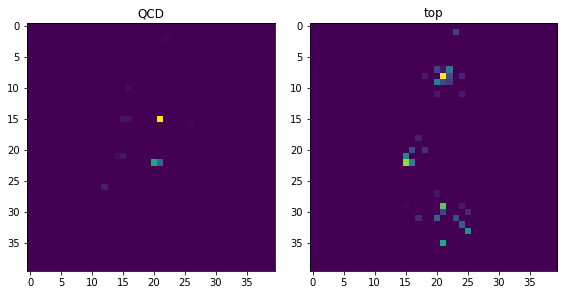

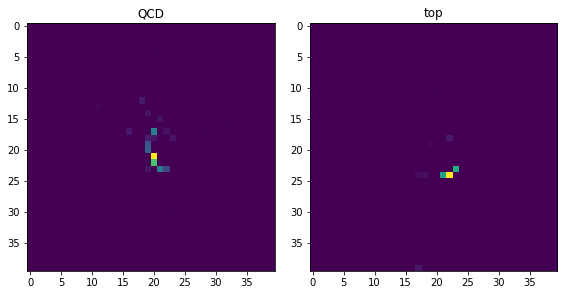

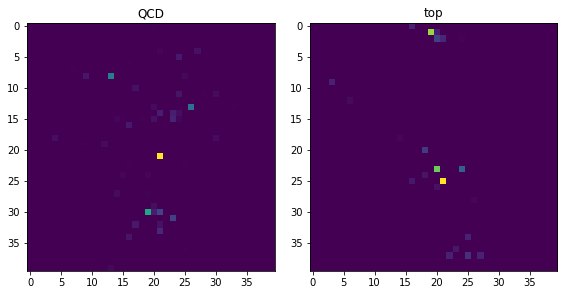

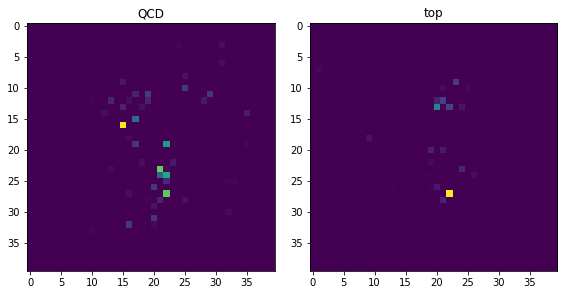

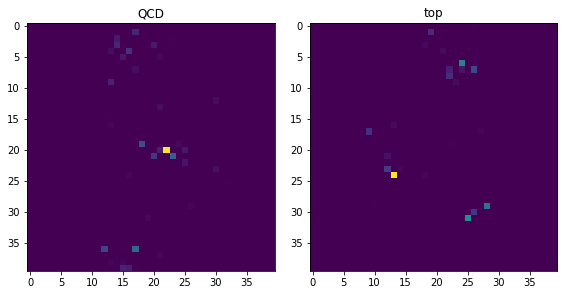

In [159]:
for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("QCD")
    plt.imshow(qcd_images[i])
    plt.subplot(1, 2, 2)
    plt.title("top")
    plt.imshow(top_images[i])
    plt.tight_layout()
    plt.show()

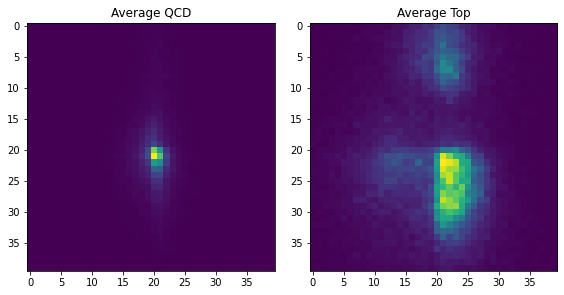

In [160]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.sum(qcd_images, axis=0))
plt.title("Average QCD")

plt.subplot(1, 2, 2)
plt.imshow(np.sum(top_images, axis=0))
plt.title("Average Top")

plt.tight_layout()
plt.show()

In [120]:
features = Features({"image": Image(), "label": ClassLabel(names=["qcd", "top"])})

In [121]:
image_ds = Dataset.from_dict(
    {"image": images[:10], "label": labels[:10]}, features=features
)

In [122]:
image_ds.features["label"].int2str(1)

'top'

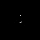

In [123]:
image_ds[0]["image"]

In [124]:
image_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 10
})

In [110]:
image_ds.push_to_hub("dl4phys/top_landscape_images")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]